In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

torch.Size([1000])


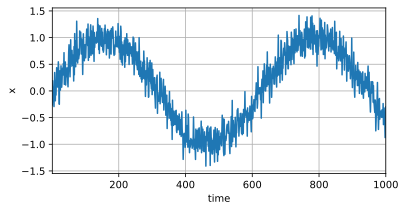

In [5]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
print(x.shape)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [9]:
# 将这个序列转换为模型的特征－标签（feature-label）
# 为我们没有足够的历史记录来描述前tau个数据样本。 
# 一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项
# 另一个方法是用零填充序列。
tau = 4
features = torch.zeros((T - tau, tau))
print(features.shape)
for i in range(tau):
     features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
print(features.shape)
print(labels.shape)
print(features[:10, 0])
print(features[:10, 1])
print(features[:10, 2])
print(labels[:10])

torch.Size([996, 4])
torch.Size([996, 4])
torch.Size([996, 1])
tensor([-0.2618,  0.1917,  0.0146, -0.2028,  0.0730, -0.2924,  0.0027,  0.3452,
         0.1039, -0.1843])
tensor([ 0.1917,  0.0146, -0.2028,  0.0730, -0.2924,  0.0027,  0.3452,  0.1039,
        -0.1843,  0.1924])
tensor([ 0.0146, -0.2028,  0.0730, -0.2924,  0.0027,  0.3452,  0.1039, -0.1843,
         0.1924, -0.0763])
tensor([[ 0.0730],
        [-0.2924],
        [ 0.0027],
        [ 0.3452],
        [ 0.1039],
        [-0.1843],
        [ 0.1924],
        [-0.0763],
        [ 0.1680],
        [ 0.4352]])


In [11]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), 
                            batch_size, is_train=True)
# 初始化权重
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)
        
# 一个简单多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
    )
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction="none")

In [13]:
# 训练
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f"epoch {epoch + 1}, "
              f"loss: {d2l.evaluate_loss(net, train_iter, loss):f}")
        
net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.077832
epoch 2, loss: 0.054561
epoch 3, loss: 0.052903
epoch 4, loss: 0.050874
epoch 5, loss: 0.053686
epoch 6, loss: 0.049440
epoch 7, loss: 0.053381
epoch 8, loss: 0.048519
epoch 9, loss: 0.050220
epoch 10, loss: 0.050485


torch.Size([996, 1])


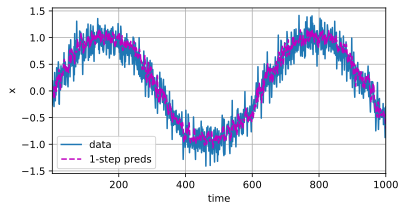

In [15]:
# 单步预测
onestep_preds = net(features)
print(onestep_preds.shape)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

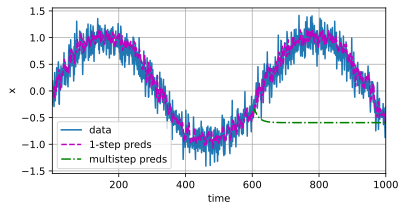

In [16]:
# K步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau: i].reshape((1, -1))
    )
    
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

观察上图绿色线，在多步预测时，由于错误的积累，误差可能会相当快地偏离真实的观测结果

torch.Size([933, 68])


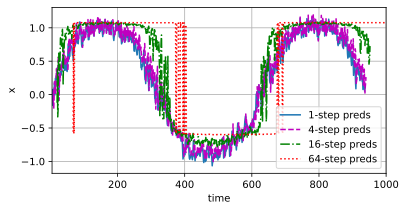

In [23]:
# K = 1, 4, 16, 64
max_steps= 64
features = torch.zeros(T - tau - max_steps + 1, tau + max_steps)
print(features.shape)

# 列i (i<tau) 是自x观测，其时间步从i到（i + T - tau - max_steps + 1)
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
    
# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

解析文本的常见预处理步骤。 这些步骤通常包括：
1. 将文本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建立一个词表，将拆分的词元映射到数字索引。
4. 将文本转换为数字索引序列，方便模型操作。

In [24]:
import collections
import re
from d2l import torch as d2l

In [28]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """ 将时间机器数据集加载到文本行的列表中 """
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    # 忽略了标点符号和字母大写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f"# 文本总行数： {len(lines)}")
for i in range(10):
    print(lines[i])

# 文本总行数： 3221
the time machine by h g wells




i


the time traveller for so it will be convenient to speak of him
was expounding a recondite matter to us his grey eyes shone and


In [31]:
# 词元化
def tokenize(lines, token="word"):  #@save
    """ 将文本行拆分为单词或字符词元 """
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token) 

word_tokens = tokenize(lines, "word")
for i in range(11):
    print(word_tokens[i])

char_tokens = tokenize(lines, "char")
for i in range(11):
    print(char_tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e', ' ', 'b', 'y', ' ', 'h', ' ', 'g', ' ', 'w', 'e', 'l', 'l', 's']
[]
[]
[]
[]
['i']
[]
[]
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 't', 'r', 'a', 'v', 'e', 'l', 'l', 'e', 'r', ' ', 'f', 'o', 'r', ' ', 's', 'o', ' ', 'i', 't', ' ', 'w', 'i', 'l', 'l', ' ', 'b', 'e', ' ', 'c', 'o', 'n', 'v', 'e', 'n', 'i', 'e', 'n', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'a', 'k', ' ', 'o', 'f', ' ', 'h', 'i', 'm']
['w', 'a', 's', ' ', 'e', 'x', 'p', 'o', 'u', 'n', 'd', 'i', 'n', 'g', ' ', 'a', ' ', 'r', 'e', 'c', 'o', 'n', 'd', 'i', 't', 'e', ' ',

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。 现在，让我们构建一个字典，通常也叫做词表（vocabulary）， 用来将字符串类型的词元映射到从
开始的数字索引中。 我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计， 得到的统计结果称之为语料（corpus）。 然后根据每个唯一词元的出现频率，为其分配一个数字索引。 很少出现的词元通常被移除，这可以降低复杂性。 另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“<unk>”。 我们可以选择增加一个列表，用于保存那些被保留的词元， 例如：填充词元（“<pad>”）； 序列开始词元（“<bos>”）； 序列结束词元（“<eos>”）。

In [51]:
class Vocab:  #@save
    """ 文本列表 """
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = self.counter_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx 
                             for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                # 已经排好序了，直接break
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        
        return [self.idx_to_token[index] for index in indices]
    
    def counter_corpus(self, tokens):  #@save
        """ 统计词元的概率 """
        if len(tokens) == 0 or isinstance(tokens[0], list):
            # 展开token，成为一个list
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)
    
    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

In [52]:
vocab = Vocab(word_tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [53]:
for i in [0, 10]:
    print('文本:', word_tokens[i])
    print('索引:', vocab[word_tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [54]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """ 返回时光机数据集的词元索引列表和词表 """
    lines = read_time_machine()
    tokens = tokenize(lines, "char")
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in lines for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
corpus, vocab = load_corpus_time_machine()
print(len(corpus))
print(len(vocab))
print(list(vocab.token_to_idx.items()))

170580
28
[('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4), ('i', 5), ('n', 6), ('o', 7), ('s', 8), ('h', 9), ('r', 10), ('d', 11), ('l', 12), ('m', 13), ('u', 14), ('c', 15), ('f', 16), ('w', 17), ('g', 18), ('y', 19), ('p', 20), ('b', 21), ('v', 22), ('k', 23), ('x', 24), ('z', 25), ('j', 26), ('q', 27)]


In [59]:
# 语言模型
# 马尔可夫模型与N元语法
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
print(vocab.token_freqs[:10])

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


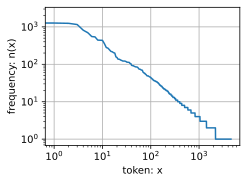

In [61]:
# 词频图
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [71]:
# 二元语法的频率
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
print(len(bigram_tokens))
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

32774


[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [74]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

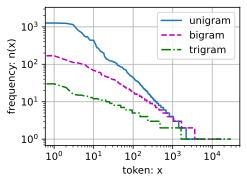

In [75]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

1. 除了一元语法词，单词序列似乎也遵循齐普夫定律
2. 词表中n元组的数量并没有那么大，这说明语言中存在相当多的结构， 这些结构给了我们应用模型的希望；
3. 很多n元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。 作为代替，我们将使用基于深度学习的模型。

In [76]:
# 读取长序列数据
# 任意长的序列可以被我们划分为具有相同时间步数的子序列。
# 当训练我们的神经网络时，这样的小批量子序列将被输入到模型中
# 可以从随机偏移量开始划分序列， 以同时获得覆盖性（coverage）和随机性（randomness）

In [78]:
# 随机采样：每个样本都是在原始的长序列上任意捕获的子序列
# 对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元
# 因此标签是移位了一个词元的原始序列。
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """ 使用随机抽样生成一个小批量子序列 """
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps - 1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1， 是为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_strps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    
    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indics包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [79]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[14, 15, 16, 17, 18],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [25, 26, 27, 28, 29]])
X:  tensor([[ 4,  5,  6,  7,  8],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [30, 31, 32, 33, 34]])
X:  tensor([[19, 20, 21, 22, 23],
        [ 9, 10, 11, 12, 13]]) 
Y: tensor([[20, 21, 22, 23, 24],
        [10, 11, 12, 13, 14]])


In [82]:
# 顺序分区
# 在迭代过程中，可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。
# 这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """ 使用顺序分区生成一个小批量子序列 """
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [84]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [85]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [86]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

循环神经网络：基于循环计算的隐状态神经网络被命名为循环神经网络
在任意时间t, 隐状态的计算可以被视为
1. 拼接当前时间步t的输入X_t，和前一时间的t-1的隐状态H_t-1
2. 将拼接的结果送入带有激活函数的全连接层，全连接层的输出是当前时间t的隐状态H_t

In [87]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-0.1345,  0.8349, -0.7103, -0.3193],
        [ 3.3130,  2.2422,  1.1212, -1.1312],
        [-0.1788,  0.8452, -0.6217, -1.1457]])

In [88]:
# 拼接
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-0.1345,  0.8349, -0.7103, -0.3193],
        [ 3.3130,  2.2422,  1.1212, -1.1312],
        [-0.1788,  0.8452, -0.6217, -1.1457]])